### Setup installation

In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


### Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple, deque
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

### Set the device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Initialize the environment

In [5]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# An environment contains brains which are responsible for deciding the actions of the agents.
# Check the brain name and set it to default
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Explore the state space and actions

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### Hyperparameters

In [7]:
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 64          # minibatch size
GAMMA = 0.99             # discounting the rewards
LR = 5e-3                # learning rate for the agent
UPDATE_EVERY = 5         # how often to update the network
TAU = 1e-3               # for soft update of target parameters

### Policy Network

In [8]:
class DQN(nn.Module):
    """
    Actor Policy Network
    """
    
    def __init__(self, state_size, action_size, fc1_units=128, fc2_units=128):
        """
        Params:
        ======
            state_size : Dimension of each state
            action_size: Dimension of each action
            fc1_units  : # nodes in the first hidden layer
            fc2_units  : # nodes in the second hidden layer
        """
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
    
    def forward(self, state):
        """
        Maps state to the action value
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### Test the output dimensions

In [9]:
# Test this network
tmp = DQN(state_size, action_size)
# The output dimension from the network is the same as action_space
tmp(torch.randn(state_size))

tensor([ 0.0529, -0.1284,  0.0162,  0.0430])

### Replay Buffer class

In [10]:
class ReplayBuffer:
    """
    Fixed size buffer to store the experiences
    """
    
    def __init__(self, action_size, batch_size, buffer_size):
        """
        Params:
        ======
            action_size : Dimesion of action space
            batch_size  : Batch size (64)
            buffer_size : Buffer size (100_000)
        """
        self.memory = deque(maxlen=buffer_size)
        self.action_size = action_size 
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        """
        Add a new tuple to the experience
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """
        Sample and return a minibatch of tuples
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """
        Returns the current length of the memory 
        """
        return len(self.memory)

#### Test the replay buffer implementation

In [11]:
# test the buffer class
tmp = ReplayBuffer(action_size, BATCH_SIZE, BUFFER_SIZE)

# Test the len function and the add experience function
print(f"Empty buffer len : {len(tmp)}")
for i in range(64):    
    tmp.add(torch.randn(state_size), 2, 10, torch.randn(state_size), 1)
print(f"Buffer len after adding 64 experiences : {len(tmp)}")

# Test the sample function
_ = tmp.sample()
print(f"Sampled {len(_[0])} states")
print(f"Sampled {len(_[1])} actions")
print(f"Sampled {len(_[2])} rewards")
print(f"Sampled {len(_[3])} next_states")
print(f"Sampled {len(_[4])} dones")

Empty buffer len : 0
Buffer len after adding 64 experiences : 64
Sampled 64 states
Sampled 64 actions
Sampled 64 rewards
Sampled 64 next_states
Sampled 64 dones


### Agent class

In [12]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = DQN(state_size, action_size).to(device)
        self.qnetwork_target = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Train the agent

In [13]:
def start_train(n_episodes=1_800, max_t=1_000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    # Initialize the agent
    agent = Agent(state_size=37, action_size=4)
    # Initialize the scores list
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    # Start episodes
    for i_episode in range(1, n_episodes+1):
        # Reset the environment
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 100
        # Start time steps
        for t in range(max_t):
            # Select action with epsilon greedy policy
            action = agent.act(state)
            # next_state, reward, done
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            # Agent takes a step, add the experience and learns
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
        # Save the models weights    
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')    
    return scores    

In [14]:
scores = start_train()

Episode 100	Average Score: 99.91
Episode 200	Average Score: 99.91
Episode 300	Average Score: 99.75
Episode 400	Average Score: 99.91
Episode 500	Average Score: 99.93
Episode 600	Average Score: 99.89
Episode 700	Average Score: 99.89
Episode 800	Average Score: 99.94
Episode 900	Average Score: 99.93
Episode 1000	Average Score: 99.99
Episode 1100	Average Score: 100.05
Episode 1200	Average Score: 100.03
Episode 1300	Average Score: 99.830
Episode 1400	Average Score: 99.96
Episode 1500	Average Score: 99.83
Episode 1600	Average Score: 99.84
Episode 1700	Average Score: 99.94
Episode 1800	Average Score: 99.79
Episode 1900	Average Score: 99.78
Episode 2000	Average Score: 99.93


### Plot the scores

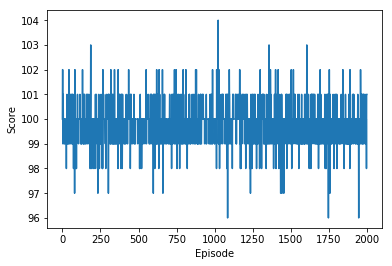

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel("Episode")
plt.show()